# Data retrieval

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [429]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [430]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,World's cheapest phone 'Freedom 251' maker's f...,The maker of world's cheapest smartphone 'Free...,technology
1,US unveils world's most powerful supercomputer...,The US has unveiled the world's most powerful ...,technology
2,FB bug changed 1.4 cr users’ privacy setting t...,Facebook has said it recently found a bug that...,technology
3,Contest for 1st couple to marry in self-drivin...,The American Automobile Association has launch...,technology
4,China's ZTE to pay $1 billion fine to US to li...,Chinese telecommunications equipment maker ZTE...,technology
5,Android Co-founder's startup unveils magnetic ...,Android Co-founder Andy Rubin's startup Essent...,technology
6,Yahoo Messenger to shut down 20 years after la...,Yahoo has announced it is discontinuing its Me...,technology
7,"Google won't design AI for weapons, surveillan...",Google CEO Sundar Pichai has clarified the com...,technology
8,Virgin Hyperloop One may allow riders to see t...,Richard Branson-led Virgin Hyperloop One has s...,technology
9,Apple patents wearable device to monitor blood...,Apple has been granted the patent for a wearab...,technology


In [431]:
news_df.news_category.value_counts()

world         25
sports        25
technology    24
Name: news_category, dtype: int64

# Text Wrangling and Pre-processing

In [2]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata

nlp = spacy.load('en_core', parse = True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

## Remove HTML tags

In [3]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Some important text</h2></html>')

'Some important text'

## Remove accented characters

In [4]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

## Expand contractions

In [5]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

## Remove special characters

In [6]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

## Text lemmatization

In [7]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crash yesterday , ours crash daily'

## Text stemming

In [8]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

## Remove stopwords

In [9]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

## Building a text normalizer

In [10]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

## Pre-process and normalize news articles

In [16]:
news_df['full_text'] = news_df["news_headline"].map(str)+ '. ' + news_df["news_article"]

In [442]:
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'clean_text': 'us unveils world powerful supercomputer beat china us unveil world powerful supercomputer call summit beat previous record holder china sunway taihulight peak performance trillion calculation per second twice fast sunway taihulight capable trillion calculation per second summit server reportedly take size two tennis court',
 'full_text': "US unveils world's most powerful supercomputer, beats China. The US has unveiled the world's most powerful supercomputer called 'Summit', beating the previous record-holder China's Sunway TaihuLight. With a peak performance of 200,000 trillion calculations per second, it is over twice as fast as Sunway TaihuLight, which is capable of 93,000 trillion calculations per second. Summit has 4,608 servers, which reportedly take up the size of two tennis courts."}

# Save the news articles

In [443]:
news_df.to_csv('news.csv', index=False, encoding='utf-8')

# Tagging Parts of Speech

In [11]:
news_df = pd.read_csv('news.csv')

In [12]:
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

sentence = str(news_df.iloc[1].news_headline)
sentence_nlp = nlp(sentence)

In [22]:
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

,Word,POS tag,Tag type
0,US,NNP,PROPN
1,unveils,VBZ,VERB
2,world,NN,NOUN
3,'s,POS,PART
4,most,RBS,ADV
5,powerful,JJ,ADJ
6,supercomputer,NN,NOUN
7,",",",",PUNCT
8,beats,VBZ,VERB
9,China,NNP,PROPN


In [24]:
nltk_pos_tagged = nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

,Word,POS tag
0,US,NNP
1,unveils,VBZ
2,world's,VBZ
3,most,RBS
4,powerful,JJ
5,"supercomputer,",JJ
6,beats,NNS
7,China,NNP


# Shallow Parsing or Chunking Text

In [132]:
from nltk.corpus import conll2000
data = conll2000.chunked_sents()

train_data = data[:10900]
test_data = data[10900:] 

print(len(train_data), len(test_data))
print(train_data[1]) 

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


In [133]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [134]:
tree = conlltags2tree(wtc) 
print(tree)

(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


In [135]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

In [136]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    if not tagged_sentence: 
        return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)

In [137]:
ntc = NGramTagChunker(train_data)
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


In [152]:
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP US/NNP)
  (VP unveils/VBZ world's/VBZ)
  (NP most/RBS powerful/JJ supercomputer,/JJ beats/NNS China/NNP))


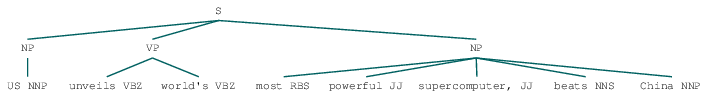

In [153]:
from IPython.display import display
os.environ['PATH'] = os.environ['PATH']+";C:\\Program Files\\gs\\gs9.09\\bin\\"
display(chunk_tree)

# Constituency parsing

In [446]:
# set java path
import os
java_path = r'C:\Program Files\Java\jdk1.8.0_102\bin\java.exe'
os.environ['JAVAHOME'] = java_path

from nltk.parse.stanford import StanfordParser

scp = StanfordParser(path_to_jar='E:/stanford/stanford-parser-full-2015-04-20/stanford-parser.jar',
                   path_to_models_jar='E:/stanford/stanford-parser-full-2015-04-20/stanford-parser-3.5.2-models.jar')
                   
result = list(scp.raw_parse(sentence))
print(result[0])

(ROOT
  (SINV
    (S
      (NP (NNP US))
      (VP
        (VBZ unveils)
        (NP
          (NP (NN world) (POS 's))
          (ADJP (RBS most) (JJ powerful))
          (NN supercomputer))))
    (, ,)
    (VP (VBZ beats))
    (NP (NNP China))))


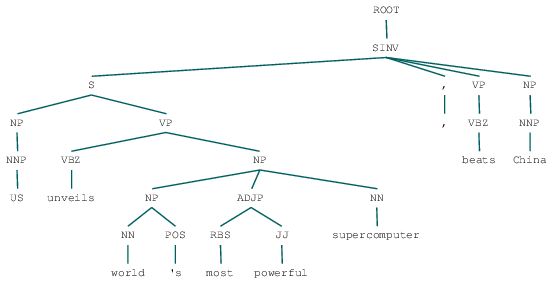

In [447]:
from IPython.display import display
os.environ['PATH'] = os.environ['PATH']+";C:\\Program Files\\gs\\gs9.09\\bin\\"
display(result[0])

# Dependency parsing

In [448]:
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n--------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_, 
                                  w_type=token.dep_,
                                  left=[t.orth_ 
                                            for t 
                                            in token.lefts],
                                  right=[t.orth_ 
                                             for t 
                                             in token.rights]))

[]<---US[compound]--->[]
--------
['US']<---unveils[nsubj]--->['supercomputer', ',']
--------
[]<---world[poss]--->["'s"]
--------
[]<---'s[case]--->[]
--------
[]<---most[amod]--->[]
--------
[]<---powerful[compound]--->[]
--------
['world', 'most', 'powerful']<---supercomputer[appos]--->[]
--------
[]<---,[punct]--->[]
--------
['unveils']<---beats[ROOT]--->['China']
--------
[]<---China[dobj]--->[]
--------


In [449]:
from spacy import displacy

displacy.render(sentence_nlp, jupyter=True, 
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

C:\Program Files\Anaconda3\lib\runpy.py:184: DeprecationWarning: Positional arguments to Doc.merge are deprecated. Instead, use the keyword arguments, for example tag=, lemma= or ent_type=.
  "__main__", mod_spec)


In [450]:
from nltk.parse.stanford import StanfordDependencyParser
sdp = StanfordDependencyParser(path_to_jar='E:/stanford/stanford-parser-full-2015-04-20/stanford-parser.jar',
                               path_to_models_jar='E:/stanford/stanford-parser-full-2015-04-20/stanford-parser-3.5.2-models.jar')    
result = list(sdp.raw_parse(sentence))  
dep_tree = [parse.tree() for parse in result][0]
print(dep_tree)

(beats (unveils US (supercomputer (world 's) (powerful most))) China)


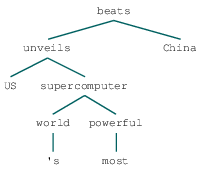

In [451]:
from IPython.display import display
os.environ['PATH'] = os.environ['PATH']+";C:\\Program Files\\gs\\gs9.09\\bin\\"
display(dep_tree)

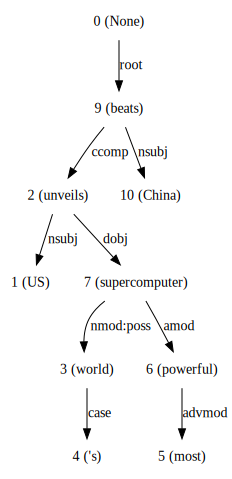

In [452]:
from graphviz import Source

dep_tree_dot_repr = [parse for parse in result][0].to_dot()
source = Source(dep_tree_dot_repr, filename="dep_tree", format="png")
source

# Named Entity Recognition

In [453]:
sentence = str(news_df.iloc[1].full_text)
sentence_nlp = nlp(sentence)

In [454]:
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

[(US, 'GPE'), (China, 'GPE'), (US, 'GPE'), (China, 'GPE'), (Sunway, 'ORG'), (TaihuLight, 'ORG'), (200,000, 'CARDINAL'), (second, 'ORDINAL'), (Sunway, 'ORG'), (TaihuLight, 'ORG'), (93,000, 'CARDINAL'), (4,608, 'CARDINAL'), (two, 'CARDINAL')]


In [455]:
displacy.render(sentence_nlp, style='ent', jupyter=True)

In [19]:
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

In [24]:
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,US,India,Indian,Singapore,Kim Jong - un,one,Apple,two,first,Messenger,China,Canadian,Facebook,Yahoo,Trump
Entity Type,GPE,GPE,NORP,GPE,PERSON,CARDINAL,ORG,CARDINAL,ORDINAL,PRODUCT,GPE,NORP,ORG,ORG,ORG
Frequency,30,12,12,11,11,10,9,8,8,7,7,6,6,6,6


In [26]:
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,PERSON,GPE,ORG,DATE,CARDINAL,NORP,EVENT,ORDINAL,PRODUCT,MONEY,TIME,LOC,FAC,QUANTITY,WORK_OF_ART
Frequency,165,126,105,67,66,58,23,21,15,11,7,5,5,3,1


In [27]:
from nltk.tag import StanfordNERTagger
import os

java_path = r'C:\Program Files\Java\jdk1.8.0_102\bin\java.exe'
os.environ['JAVAHOME'] = java_path

sn = StanfordNERTagger('E:/stanford/stanford-ner-2014-08-27/classifiers/english.all.3class.distsim.crf.ser.gz',
                       path_to_jar='E:/stanford/stanford-ner-2014-08-27/stanford-ner.jar')

ner_tagged_sentences = [sn.tag(sent.split()) for sent in corpus]

In [28]:
named_entities = []
for sentence in ner_tagged_sentences:
    temp_entity_name = ''
    temp_named_entity = None
    for term, tag in sentence:
        if tag != 'O':
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

#named_entities = list(set(named_entities))
entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

In [30]:
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head(15)

,Entity Name,Entity Type,Frequency
0,US,LOCATION,31
1,Donald Trump,PERSON,13
2,India,LOCATION,13
3,Trump,PERSON,12
4,Singapore,LOCATION,11
5,Kim Jong-un,PERSON,9
6,Facebook,ORGANIZATION,9
7,Yahoo,ORGANIZATION,6
8,Kim,PERSON,6
9,Nadal,PERSON,6


In [462]:
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head()

,Entity Type,Frequency
0,PERSON,186
1,LOCATION,125
2,ORGANIZATION,54


# Emotion and Sentiment Analysis

In [13]:
from afinn import Afinn

af = Afinn()

In [14]:
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]

In [15]:
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                           
                        count  mean       std   min  25%  50%  75%   max
news_category                                                           
sports                   25.0  2.16  7.363649 -10.0 -3.0  0.0  7.0  20.0
technology               24.0 -0.25  4.936554 -15.0 -4.0  0.0  3.0   6.0
world                    25.0  1.48  6.042351 -12.0 -1.0  1.0  5.0  16.0

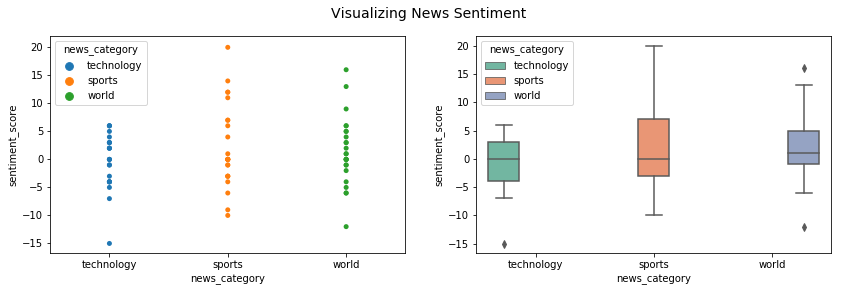

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

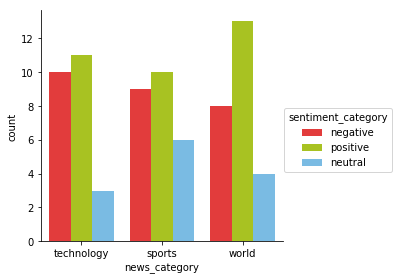

In [40]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [41]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 6)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -15)].index[0]

print('Most Negative Tech News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Tech News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Tech News Article: The maker of world's cheapest smartphone 'Freedom 251' priced at ₹251, Ringing Bells' founder Mohit Goel was arrested along with two more people by the Delhi Police on Sunday. The three were allegedly trying to extort money in lieu of settling a rape case. Last year, Goel was arrested over allegations of fraud and an alleged non-payment of ₹16 lakh.

Most Positive Tech News Article: The American Automobile Association has launched a contest to find the first couple to get married in one of its self-driving shuttles in Las Vegas. The contestants will have to write a 400-word essay describing how an autonomous vehicle would have changed their road trip experience with their partner. The winning couple will be married on June 30.


In [42]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 16)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -12)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: Slamming Canadian Prime Minister Justin Trudeau's comments on US tariffs during the G7 summit, US President Donald Trump's trade adviser Peter Navarro said, "Trudeau deserves a special place in hell." Navarro also accused Trudeau of backstabbing Trump. The Canadian PM had called US tariffs "insulting", saying the country won't be pushed around and plans to apply retaliatory tariffs.

Most Positive World News Article: Pope Francis on Sunday said he is praying that the upcoming summit between US President Donald Trump and North Korean leader Kim Jong-un succeeds in laying the groundwork for peace. Urging people around the world to pray for the summit, the pontiff said, "I want to offer the beloved people of Korea an especial thought of friendship."


In [16]:
from textblob import TextBlob

sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]

In [17]:
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                             \
                        count      mean       std    min      25%    50%   
news_category                                                              
sports                   25.0  0.084040  0.149114 -0.200 -0.01700  0.075   
technology               24.0  0.010458  0.203315 -0.500 -0.07525  0.000   
world                    25.0  0.120760  0.221134 -0.296  0.00000  0.075   

                               
                   75%    max  
news_category                  
sports         0.15900  0.381  
technology     0.05925  0.500  
world          0.21100  0.700

In [18]:
df.head()

,news_category,sentiment_score,sentiment_category
0,technology,-0.058,negative
1,technology,0.119,positive
2,technology,-0.022,negative
3,technology,0.363,positive
4,technology,0.078,positive


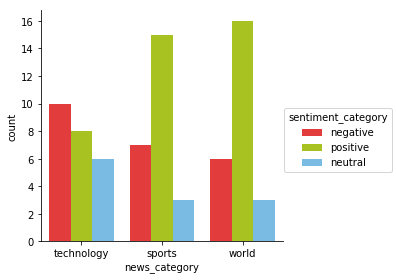

In [74]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [75]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 0.7)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -0.296)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: A Czech woman drowned after being trapped inside Prague's underground drainage system while participating in a global GPS-based treasure hunt, police officials said. The woman was geocaching when heavy downpours led to rapidly rising water. The body of the 27-year-old victim, who has not been identified, was found in the Vltava river.   

Most Positive World News Article: Pope Francis on Sunday said he is praying that the upcoming summit between US President Donald Trump and North Korean leader Kim Jong-un succeeds in laying the groundwork for peace. Urging people around the world to pray for the summit, the pontiff said, "I want to offer the beloved people of Korea an especial thought of friendship."


In [20]:
import model_evaluation_utils as meu
meu.display_confusion_matrix_pretty(true_labels=sentiment_category, 
                                    predicted_labels=sentiment_category_tb, 
                                    classes=['negative', 'neutral', 'positive'])

Predicted:                 
                   negative neutral positive
Actual: negative         16       5        6
        neutral           3       2        8
        positive          4       5       25